<a href="https://colab.research.google.com/github/taba1/test1/blob/master/rbc_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install autograd

In [3]:
!pip install matplotlib
!pip install scipy
!pip install matplotlib
!pip install --upgrade matplotlib

Steady state: [ 1.      1.0204 45.6371  4.6103  3.6975  0.    ]
Debug - X_lag [ 1.      1.0204 45.6371  4.6103  3.6975  0.    ]
Debug - X [ 1.      1.0204 45.6371  4.6103  3.6975  0.    ]
Debug - X_prime [ 1.      1.0204 45.6371  4.6103  3.6975  0.    ]
Debug - X_lag [ 1.      1.0204 45.6371  4.6103  3.6975  0.    ]
Debug - X [ 1.      1.0204 45.6371  4.6103  3.6975  0.    ]
Debug - X_prime Autograd ArrayBox with value [ 1.      1.0204 45.6371  4.6103  3.6975  0.    ]
Debug - X_lag [ 1.      1.0204 45.6371  4.6103  3.6975  0.    ]
Debug - X Autograd ArrayBox with value [ 1.      1.0204 45.6371  4.6103  3.6975  0.    ]
Debug - X_prime [ 1.      1.0204 45.6371  4.6103  3.6975  0.    ]
Debug - X_lag Autograd ArrayBox with value [ 1.      1.0204 45.6371  4.6103  3.6975  0.    ]
Debug - X [ 1.      1.0204 45.6371  4.6103  3.6975  0.    ]
Debug - X_prime [ 1.      1.0204 45.6371  4.6103  3.6975  0.    ]
Debug - X_lag [ 1.      1.0204 45.6371  4.6103  3.6975  0.    ]
Debug - X [ 1.      1.020

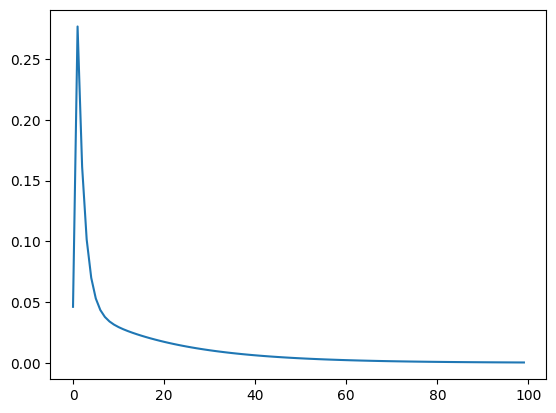

In [7]:
from os import RTLD_DEEPBIND
import autograd.numpy as np
from autograd import jacobian
np.set_printoptions(suppress=True,precision=4)

from Support import SolveSystem

# Indexing
nX = 6
nEps = 1
iZ, iR, iK, iY, iC, iQ = range(nX)


# Parameters
alpha = 0.4
beta = 0.98
gamma = 2.0
delta = 0.02
rho = 0.95
beta_Y =0.0



def SteadyState():
    Z = 1.
    R = 1/beta
    K = ((R-1+delta)/alpha)**(1./(alpha-1))
    Q = K
    Y = K**alpha
    C = Y - delta*K

    X = np.zeros(nX)
    X[[iZ, iR, iK, iY, iC]] = (Z, R, K, Y, C)
    return X

X_SS = SteadyState()
epsilon_SS = 0.0
print("Steady state: {}".format(X_SS))

# Model equations
def F(X_Lag,X,X_Prime,epsilon):

    # Unpack
    Z, R, K, Y, C,Q = X
    Z_L, R_L, K_L, Y_L, C_L,Q_L = X_Lag
    Z_P, R_P, K_P, Y_P, C_P,Q_P = X_Prime

    print("Debug - X_lag",X_Lag)
    print("Debug - X",X )
    print("Debug - X_prime",X_Prime)

    return np.hstack((

            beta *Q*C_P**(-gamma) * C**gamma - Q_P, # Euler equation
            alpha * Z  * K_L **(alpha-1) + 1 -delta - R, # MPK
            (1-delta) * K_L + Y - C - K,# Aggregate resource constraint
            Z * K_L**alpha - Y,# Production function
            Q_P-R_P*Q, #+np.log(Z),
            rho * np.log(Z_L) + epsilon - np.log(Z)# TFP evolution
            ))


# Check steady state
assert( np.allclose( F(X_SS,X_SS,X_SS,epsilon_SS) , np.zeros(nX)))


# Linearize
A = jacobian(lambda x: F(X_SS,X_SS,x,epsilon_SS))(X_SS)
B = jacobian(lambda x: F(X_SS,x,X_SS,epsilon_SS))(X_SS)
C = jacobian(lambda x: F(x,X_SS,X_SS,epsilon_SS))(X_SS)
E = jacobian(lambda x: F(X_SS,X_SS,X_SS,x))(epsilon_SS)




P, Q = SolveSystem(A,B,C,E)


# Calculate an impulse response
IRF_RBC = np.zeros((nX,100))
IRF_RBC[:,0] = Q * 0.01

for t in range(1,100):
    IRF_RBC[:,t] = P@IRF_RBC[:,t-1]


# This material below runs only if this file is executed as a script
if __name__ == "__main__":


    print("A: {}".format(A))
    print("B: {}".format(B))
    print("C: {}".format(C))
    print("E: {}".format(E))

    import matplotlib.pyplot as plt
    plt.plot(IRF_RBC[iY,:])